In [105]:
import torch.nn as nn
import torch
import torch.utils.data as Data

In [4]:
from scipy.io import loadmat

In [7]:
df = loadmat('./data/cardio.mat')

In [12]:
X = torch.from_numpy(df['X'])
X

tensor([[ 0.0049,  0.6932, -0.2036,  ...,  0.2315, -0.2898, -0.4933],
        [ 0.1107, -0.0799, -0.2036,  ...,  0.0936, -0.2564, -0.4933],
        [ 0.2165, -0.2724, -0.2036,  ...,  0.0246, -0.2564,  1.1400],
        ...,
        [-0.4184, -0.9200, -0.1646,  ..., -1.4927,  0.2446, -0.4933],
        [-0.4184, -0.9200, -0.1509,  ..., -1.4237,  0.1444, -0.4933],
        [-0.4184, -0.9200, -0.2036,  ..., -1.2858,  3.5847, -0.4933]],
       dtype=torch.float64)

In [13]:
y = torch.from_numpy(df['y'])
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]], dtype=torch.float64)

In [89]:
class TorchDataSplitter():
    def __init__(self, ratio=[0.7, 0.3]):
        '''
        ratio: the ratio of the amount of data in each subset, the
        sum of ratio should be equal to 1.
        '''
        self.ratio = ratio
        if sum(ratio) != 1:
            raise ValueError('the sum of ratio is not equal to 1')

    def split_random(self, X, y=None, random_seed=1):
        '''
        Split the data randomly.
        X: multi-dimensional point data
        y: optional, labels
        random_seed: the random seed for torch.Generator.manual_seed()
        return a list contains several torch tensor object, the order is
        as follows: [X_1, y_1, X_2, y_2..., X_len(ratio), y_len(ratio)]
        '''
        if y is not None:
            if len(X) != len(y):
                raise RuntimeError('the sizes of X and y are different')
        x_size = len(X)
        split_list = [int(x_size * self.ratio[0])]
        p_sum = self.ratio[0]
        for i in range(len(self.ratio) - 1):
            p_sum += self.ratio[i + 1]
            split_list.append(int(x_size * p_sum) - sum(split_list))
            print(split_list)
        subset_list = torch.utils.data.random_split(X, split_list, generator=torch.Generator().manual_seed(random_seed))
        return_list = []
        for i in subset_list:
            return_list.append(X[i.indices])
            if y is not None:
                return_list.append(y[i.indices])
        return return_list

    def split_inorder(self, X, y=None):
        '''
        Split the data in order.
        X: multi-dimensional point data
        y: optional, labels
        return a list contains several torch tensor object, the order is
        as follows: [X_1, y_1, X_2, y_2..., X_len(ratio), y_len(ratio)]
        '''
        if y is not None:
            if len(X) != len(y):
                raise RuntimeError('the sizes of X and y are different')
        x_size = len(X)
        split_list = [int(x_size * self.ratio[0])]
        p_sum = self.ratio[0]
        for i in range(len(self.ratio) - 1):
            p_sum += self.ratio[i + 1]
            split_list.append(int(x_size * p_sum) - sum(split_list))
        X_split = torch.split(X, split_list)
        if y is not None:
            y_split = torch.split(y, split_list)
        return_list = []
        for i in range(len(self.ratio)):
            return_list.append(X_split[i])
            if y is not None:
                return_list.append(y_split[i])
        return return_list

In [93]:
split_model = TorchDataSplitter([2/3,1/3])

In [97]:
X_train, y_train, X_test, y_test = split_model.split_random(X,y)

[1220, 611]


In [98]:
X_train

tensor([[-0.1009,  1.7953, -0.2036,  ...,  0.5763, -0.3900,  1.1400],
        [ 1.1689,  0.2378, -0.2036,  ...,  0.8522, -0.5570, -0.4933],
        [-0.3125, -0.2873,  0.1304,  ..., -0.1823, -0.5904,  1.1400],
        ...,
        [-2.1114,  0.3147, -0.2036,  ..., -1.6306, -0.3900, -0.4933],
        [ 1.0631, -0.2830, -0.2036,  ..., -0.2513,  2.0816, -0.4933],
        [ 0.9573, -0.6686, -0.2036,  ...,  0.8522, -0.6572,  1.1400]],
       dtype=torch.float64)

In [99]:
X_test

tensor([[-1.6882, -0.9200, -0.2036,  ..., -1.0789, -0.5904,  1.1400],
        [-0.1009, -0.9200, -0.2036,  ...,  0.1625,  0.7456,  1.1400],
        [ 0.1107,  1.0555,  0.1532,  ...,  0.3005,  0.0442,  1.1400],
        ...,
        [ 1.0631, -0.6249, -0.2036,  ...,  0.1625,  0.7122, -0.4933],
        [-0.6300, -0.9200, -0.2036,  ..., -0.1823, -0.5904,  1.1400],
        [ 0.4282, -0.4692, -0.2036,  ...,  0.3694, -0.6906, -0.4933]],
       dtype=torch.float64)

In [100]:
sum(y_train)

tensor([114.], dtype=torch.float64)

In [101]:
sum(y_test)

tensor([62.], dtype=torch.float64)

In [122]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(21, 12),
            nn.Tanh(),
            nn.Linear(12, 6),
            nn.Tanh(),
            nn.Linear(6, 2),
            nn.Tanh(),   
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 6),
            nn.Tanh(),
            nn.Linear(6, 12),
            nn.Tanh(),
            nn.Linear(12, 21),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

autoencoder = AutoEncoder()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
loss_func = nn.MSELoss()

In [123]:
X_train = X_train.float()
y_train = y_train.float()
X_test = X_test.float()
y_test = y_test.float()

In [124]:
EPOCH = 50
BATCH_SIZE = 244
train_loader = Data.DataLoader(
    dataset=X_train,      
    batch_size=BATCH_SIZE,      
    shuffle=True,              
    num_workers=2,             
)


In [125]:
for epoch in range(EPOCH):
    for step, x in enumerate(train_loader):
        b_x = x.view(-1, 21)   # batch x, shape (batch, 28*28)
        b_y = x.view(-1, 21)   # batch y, shape (batch, 28*28)

        encoded, decoded = autoencoder(b_x)

        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()  
        loss += loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, EPOCH, loss))

epoch : 1/50, loss = 0.478785
epoch : 2/50, loss = 0.472608
epoch : 3/50, loss = 0.450449
epoch : 4/50, loss = 0.502696
epoch : 5/50, loss = 0.436897
epoch : 6/50, loss = 0.422665
epoch : 7/50, loss = 0.401360
epoch : 8/50, loss = 0.422840
epoch : 9/50, loss = 0.397002
epoch : 10/50, loss = 0.351583
epoch : 11/50, loss = 0.363823
epoch : 12/50, loss = 0.396459
epoch : 13/50, loss = 0.379247
epoch : 14/50, loss = 0.348426
epoch : 15/50, loss = 0.357956
epoch : 16/50, loss = 0.397847
epoch : 17/50, loss = 0.374948
epoch : 18/50, loss = 0.324305
epoch : 19/50, loss = 0.364593
epoch : 20/50, loss = 0.386151
epoch : 21/50, loss = 0.370817
epoch : 22/50, loss = 0.319742
epoch : 23/50, loss = 0.354031
epoch : 24/50, loss = 0.367593
epoch : 25/50, loss = 0.344932
epoch : 26/50, loss = 0.333374
epoch : 27/50, loss = 0.307024
epoch : 28/50, loss = 0.380907
epoch : 29/50, loss = 0.333162
epoch : 30/50, loss = 0.327991
epoch : 31/50, loss = 0.347076
epoch : 32/50, loss = 0.345465
epoch : 33/50, lo

In [128]:
import matplotlib.pyplot as plt
plt.scatter(autoencoder(X_train)[0])

TypeError: scatter() missing 1 required positional argument: 'y'

In [154]:
import numpy as np
lower_dimension_data = autoencoder(X_test)[0].detach().numpy()

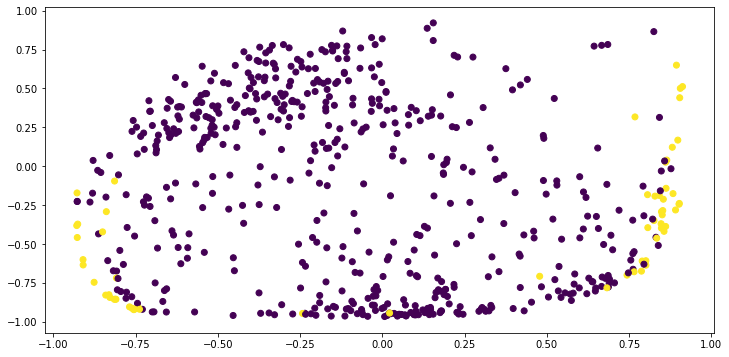

In [158]:
plt.figure(figsize = (12,6))
plt.scatter(lower_dimension_data[:,0], lower_dimension_data[:,1], c = y_list)
plt.show()

In [155]:
y_list = y_test.detach().numpy()

In [156]:
y_list = [int(i) for i in y_list]


In [157]:
y_list

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
